<a href="https://colab.research.google.com/github/carlaolivei/Hackathon-Motor-Pegabot/blob/main/New-Model-From-INCT-DD-Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Elaboração de um novo modelo de classificação com base nas informações de usuários avaliados pelo INCT-DD**

In [62]:
#Carrega as bibliotecas
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, matthews_corrcoef, mean_squared_error, r2_score, mean_absolute_percentage_error, max_error, explained_variance_score, median_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, classification_report
import math
import statistics
import datetime
import pytz
import pickle
## NLTK (biblioteca para processamento de linguagem natural)
import nltk
nltk.download('rslp')
nltk.download('stopwords')
from nltk.stem.rslp import RSLPStemmer ##http://www.nltk.org/howto/portuguese_en.html
from nltk.corpus import stopwords

#O primeiro uso exige obter os pacotes adicionais da biblioteca descomentando as linhas a seguir
#Instala os pacotes de termos do nltk (apenas na primeira vez)
#nltk.download()
#nltk.download('rslp')

[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**O novo modelo de classificação de bots foi construído com base nos usuários manualmente avaliados pelo INCT-DD**

Essa escolha foi tomada considerando que esse conjunto de dados é o melhor que se possui quanto à real possibilidade de um usuário do Twitter ser um bot, não existindo bases de avaliação dentro da realidade brasileira (especialmente quanto ao português), bem como atualizadas

In [2]:
#Busca os dados dos usuários avaliados
datafile_users = "/content/sample_data/inct_users.csv"
df_users = pd.read_csv(datafile_users, header = 0)

#Preenche os valores NaN con 0 apenas para avaliação geral
df_users = df_users.fillna(0)
print(len(df_users))
#Apresenta o total de usuários avaliados
df_users.head()

1074


,Unnamed: 0,error,created_at,default_profile,description,followers_count,friends_count,handle,lang,location,name,profile_image,twitter_id,twitter_is_protected,verified,withheld_in_countries
0,0,0,2009-06-30 01:05:51+00:00,1.0,0,21.0,108.0,lemathes,0.0,"Brasil, São Paulo",Leandro Mathes,http://pbs.twimg.com/profile_images/1141547105...,5.225325e+07,0.0,0.0,[]
1,1,0,2019-03-09 11:29:52+00:00,True,0,4192.0,4886.0,Maurcio98905595,0.0,"MG , Brasil",Maurício Lima,http://pbs.twimg.com/profile_images/1104354755...,1.104344e+18,False,False,[]
2,2,0,2009-10-20 01:19:19+00:00,False,Feliz é a Nação cujo Deus é o Senhor! #ReageBr...,1341.0,1854.0,LunViana,0.0,"Araraquara, Brasil",Luciana,http://pbs.twimg.com/profile_images/1436716357...,8.373752e+07,False,False,[]
3,3,0,2020-05-03 19:06:46+00:00,True,0,2.0,31.0,felipeleixas,0.0,0,Felipe,http://pbs.twimg.com/profile_images/1264366970...,1.257024e+18,False,False,[]
4,4,0,2021-04-25 20:04:17+00:00,True,0,10.0,21.0,JoseCar41451194,0.0,0,Jose Carlos Marques de Albuquerque,http://pbs.twimg.com/profile_images/1429559356...,1.386411e+18,False,False,[]


**No novo modelos são consideradas apenas as informações associadas como "É bot?" de respotas "Sim" ou "Não"**

In [3]:
#Busca a classificação do INCT-DD
datafile_handles = "/content/sample_data/handles_inct.csv" #A classificação é a mesma da sample1
df_handles = pd.read_csv(datafile_handles, header = 0)
print(len(df_handles))
df_handles['É Bot?'].head()

1074


0    não
1    não
2    não
3    sim
4    Não
Name: É Bot?, dtype: object

In [4]:
df_handles.head()

,Unnamed: 0,Unnamed: 0.1,tabelaAmostra,p,É Bot?,"Se você fosse atribuir uma função ao bot, qual seria?",Função #2,Comportamento agressivo?,Comportamento repetitivo com # ou menções?,Parece só Retweetar?,Só compartilha links?,Só faz comentários?,Enaltece muito outros usuários?,Faz muito uso de emojis?,Tem muitos posts sem textos?,Unnamed: 14,handle
0,0,1,https://twitter.com/@lemathes,0000.csv,não,não se aplica,NaN,não,não,não,não,não,não,não,não,NaN,lemathes
1,1,2,https://twitter.com/@Maurcio98905595,0000.csv,não,não se aplica,NaN,não,não,não,não,não,não,não,não,NaN,Maurcio98905595
2,2,3,https://twitter.com/@LunViana,0000.csv,não,não se aplica,NaN,não,não,não,não,não,não,não,não,NaN,LunViana
3,3,4,https://twitter.com/@felipeleixas,0000.csv,sim,Publicar hashtags,Atacar,sim,sim,não,não,não,não,não,não,NaN,felipeleixas
4,4,5,https://twitter.com/@JoseCar41451194,0000.csv,Não,não se aplica,NaN,não,não,não,não,não,não,não,não,NaN,JoseCar41451194


**As mais recentes postagens dos usuários foram consideradas como um atributo do modelo**

Para a classificação dos usuários, o novo modelo inclui atributos relacionados com as postagens dos usuários, na tentativa de extrair informação mais atualizada e dinâmica de sua atuação. Entretanto, os textos das postagens foram utilizados unificando seus conteúdos e extraindo informações representativas, tais como os termos mais recorrentemente utilizados, diferença no tempo das postagens e repostagens

In [5]:
#Recupera os últimos twittes
datafile_timeline = "/content/sample_data/inct_timelines.csv"
df_timeline = pd.read_csv(datafile_timeline, header = 0)
print(len(df_timeline))
df_timeline.head(1)

82413


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (7,8,12,15) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Unnamed: 0,error,tweet_author,tweet_author_id_str,tweet_contributors,tweet_created_at,tweet_favorite_count,tweet_favorited,tweet_geo,tweet_hashtags,tweet_id,tweet_id_str,tweet_is_retweet,tweet_lang,tweet_place,tweet_retweeted,tweet_source,tweet_text
0,0,NaN,lemathes,52253248,NaN,2022-03-09 02:10:58+00:00,0.0,0.0,NaN,[],1.501380e+18,1501379987747876874,0.0,pt,NaN,0.0,Twitter for Android,@LucianoHangBr Já demorou muito!


Aplica um pré-processamento nos dados para unificar a informação da postagens se tratar de um retweet

In [6]:
#identifica os formatos existentes
df_timeline['tweet_is_retweet'].unique()

array(['0.0', 'False', 'True', False, True], dtype=object)

In [7]:
df_timeline['retweet_tratado'] = df_timeline['tweet_is_retweet'].apply(lambda x: "sim" if (x == 'True' or x == True) else "não")
df_timeline['retweet_tratado'].unique()

array(['não', 'sim'], dtype=object)

In [8]:
#Necessário reverificar no texto do tweet por RT @, pois o campo tweet_is_retweet falha em algumas situações não identificadas
#Parecem ser os RT com comentários adicionais
#for tweet in df_timeline['retweet_tratado', 'tweet_text']:
#    if tweet['retweet_tratado'] == 'não':
#        if tweet['tweet_text'].find("RT @") != -1:
#            tweet['retweet_tratado'] = 'sim'
#len(df_timeline)
#for i in range(len(df_timeline)):
#    if df_timeline.iloc[i]['retweet_tratado'] == 'não':
#        if df_timeline.iloc[i]['tweet_text'].find("RT @") != -1:
#            df_timeline.iloc[i]['retweet_tratado']  = 'sim'
df_timeline['tweet_com_rt_tratado'] = df_timeline['tweet_text'].apply(lambda x: "sim" if x.find("RT @") != -1 else "não" )
df_timeline['tweet_com_rt_tratado']

0        não
1        sim
2        não
3        não
4        não
        ... 
82408    sim
82409    sim
82410    sim
82411    sim
82412    não
Name: tweet_com_rt_tratado, Length: 82413, dtype: object

In [9]:
#Combina em uma única coluna as informações de retweets e tweets com RT comentados
def reune_rt(retweet,rt):
    if retweet == 'sim' or rt == 'sim':
        return 'sim'
    else:
        return 'não'

df_timeline['retweet_e_tweet_com_rt_tratado'] = df_timeline.apply(lambda x: reune_rt(x.retweet_tratado, x.tweet_com_rt_tratado), axis=1)
df_timeline.head(2)

,Unnamed: 0,error,tweet_author,tweet_author_id_str,tweet_contributors,tweet_created_at,tweet_favorite_count,tweet_favorited,tweet_geo,tweet_hashtags,...,tweet_id_str,tweet_is_retweet,tweet_lang,tweet_place,tweet_retweeted,tweet_source,tweet_text,retweet_tratado,tweet_com_rt_tratado,retweet_e_tweet_com_rt_tratado
0,0,NaN,lemathes,52253248,NaN,2022-03-09 02:10:58+00:00,0.0,0.0,NaN,[],...,1501379987747876874,0.0,pt,NaN,0.0,Twitter for Android,@LucianoHangBr Já demorou muito!,não,não,não
1,1,NaN,lemathes,52253248,NaN,2022-03-09 02:10:12+00:00,0.0,False,NaN,[],...,1501379796210757632,False,pt,NaN,False,Twitter for Android,RT @LucianoHangBr: A vida precisa continuar e ...,não,sim,sim


In [10]:
df_timeline[df_timeline["retweet_e_tweet_com_rt_tratado"] == 'sim']

,Unnamed: 0,error,tweet_author,tweet_author_id_str,tweet_contributors,tweet_created_at,tweet_favorite_count,tweet_favorited,tweet_geo,tweet_hashtags,...,tweet_id_str,tweet_is_retweet,tweet_lang,tweet_place,tweet_retweeted,tweet_source,tweet_text,retweet_tratado,tweet_com_rt_tratado,retweet_e_tweet_com_rt_tratado
1,1,NaN,lemathes,52253248,NaN,2022-03-09 02:10:12+00:00,0.0,False,NaN,[],...,1501379796210757632,False,pt,NaN,False,Twitter for Android,RT @LucianoHangBr: A vida precisa continuar e ...,não,sim,sim
5,5,NaN,lemathes,52253248,NaN,2022-02-27 13:38:14+00:00,0.0,False,NaN,[],...,1497929065302482946,False,pt,NaN,False,Twitter for Android,"RT @roxmo: Puxa, que pena, passou tão perto!… ...",não,sim,sim
6,6,NaN,lemathes,52253248,NaN,2022-02-18 04:17:53+00:00,0.0,False,NaN,[],...,1494526561902546944,False,pt,NaN,False,Twitter for Android,RT @mila_sayuri: Alguém poderia confirmar se e...,não,sim,sim
7,7,NaN,lemathes,52253248,NaN,2022-02-18 04:11:31+00:00,0.0,False,NaN,[],...,1494524957593845762,False,pt,NaN,False,Twitter for Android,RT @RenzoGracieBJJ: Quando postei aqui o vídeo...,não,sim,sim
8,8,NaN,lemathes,52253248,NaN,2022-02-18 04:10:00+00:00,0.0,False,NaN,[],...,1494524573919940609,False,pt,NaN,False,Twitter for Android,RT @roxmo: Vc confia nas urnas eletrônicas?,não,sim,sim
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82406,82406,NaN,FATIMAC75843178,1349784643244093440,NaN,2022-03-17 12:10:29+00:00,0.0,False,NaN,[],...,1504429966729138176,False,pt,NaN,False,Twitter for Android,RT @EdmarVencedor: @BelaBonoro @OsvaldoLimaJni...,não,sim,sim
82408,82408,NaN,FATIMAC75843178,1349784643244093440,NaN,2022-03-17 12:09:52+00:00,0.0,False,NaN,[],...,1504429810352898052,False,pt,NaN,False,Twitter for Android,RT @BelaBonoro: @OsvaldoLimaJni1 @CeliaSLeao1 ...,não,sim,sim
82409,82409,NaN,FATIMAC75843178,1349784643244093440,NaN,2022-03-17 12:09:18+00:00,0.0,False,NaN,[],...,1504429669613031426,False,pt,NaN,False,Twitter for Android,RT @carlosjordy: Ciro sincero diz de quem é a ...,não,sim,sim
82410,82410,NaN,FATIMAC75843178,1349784643244093440,NaN,2022-03-17 12:08:46+00:00,0.0,False,NaN,[],...,1504429535818924033,False,pt,NaN,False,Twitter for Android,RT @CarlaZambelli38: ATENÇÃO ao alerta do Pres...,não,sim,sim


Extrai a diferença em segundos entre as postagens do usuário

In [11]:
#Incluir uma dedida da distancia temporal entre twittes (mediana e mínimo)
df_handles['Tempo mediano'] = np.array(len(df_handles))
df_handles['Tempo menor']   = np.array(len(df_handles))
iuser = 0
for user in df_handles['handle']:
    df_temp = df_timeline[df_timeline['tweet_author'] == user]
    itweet = 0
    menor = 100000
    difs = list()
    tweet_date_prev = None
    for tweet in df_temp['tweet_created_at']:
        tweet_date = pd.to_datetime(pd.to_datetime(tweet).strftime("%Y-%m-%dT%H:%M:%S.%fZ"))
        if itweet > 0:
            dif = (tweet_date_prev - tweet_date).seconds
            if dif < menor:
                menor = dif
            difs.append(dif)
        else:
            tweet_date_prev = tweet_date
        tweet_date_prev = tweet_date
        itweet += 1
    if len(difs) > 0:
        mediana = statistics.median(difs)
    else:
        mediana = 1000
    print(user + ' - ' + str(menor) + ' - ' + str(mediana)+'\n')
    df_handles['Tempo mediano'][iuser] = mediana
    df_handles['Tempo menor'][iuser]   = menor
    iuser += 1
    
    

lemathes - 16 - 1917

Maurcio98905595 - 1 - 22

LunViana - 2 - 34

felipeleixas - 141 - 40791.0

JoseCar41451194 - 9 - 584

stefmilhori - 0 - 862

Maurio0916 - 11 - 7975

alaincremonezi - 7 - 210

marctrickguedes - 24 - 436

Valdir_25 - 16 - 10217



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


HermesMachadoAP - 26 - 3416

euclaudemir - 4 - 8076

LongoMarlongo - 5 - 117

Tadeu88537223 - 4 - 147

EliasBispodeCe1 - 3 - 63

lessa_tadeu - 100000 - 1000

kentyan71 - 4 - 136

Sirenite1 - 1 - 142

elechimamil - 6 - 423

mhelena17 - 4 - 74

victorcalazans - 15 - 405

AnaPedros2308 - 4 - 136

ricardo_lacava - 24 - 235

AslanDeHogwarts - 10 - 1933

Patriota7M - 0 - 24

luGusmao1 - 2 - 15

GilAndrade5 - 6 - 66

ClaytonSampaio5 - 0 - 20900

filhadefridak - 17 - 14945

lucas_neves164 - 100000 - 1000

Thiago48035185 - 6 - 71

herciconti - 0 - 110

FlaviaPauletti - 13 - 2250

ElielAmorim9 - 14 - 207

Lunar_Vante - 6 - 380

lemosmarl - 3 - 10776

joaocarlosjc - 5 - 1533

georgedebarros - 16 - 314

valterpn - 2 - 290

Mariade25585540 - 5 - 249

NTresolavy - 6 - 193

jonny_1309 - 3 - 27605

Dani_BernMor - 16 - 652

lui45807682 - 2 - 180

OluasSnanaj - 22 - 2964

abreumartha - 7 - 104

deuzemaroliveir - 5 - 49

Tahuamello - 100000 - 1000

BorjaoOp - 100000 - 1000

MelchiranL - 3 - 4607

_mcalhe

**Os dados inicialmente tratados são reunidos com a classificação dada pelo INCT-DD**

In [12]:
#Reune os dados do usuário com a classificação
df_result_merge = pd.merge(df_handles, df_users, on=['handle'])
print(len(df_result_merge))
df_result_merge.head(1)

1072


,Unnamed: 0_x,Unnamed: 0.1,tabelaAmostra,p,É Bot?,"Se você fosse atribuir uma função ao bot, qual seria?",Função #2,Comportamento agressivo?,Comportamento repetitivo com # ou menções?,Parece só Retweetar?,...,followers_count,friends_count,lang,location,name,profile_image,twitter_id,twitter_is_protected,verified,withheld_in_countries
0,0,1,https://twitter.com/@lemathes,0000.csv,não,não se aplica,NaN,não,não,não,...,21.0,108.0,0.0,"Brasil, São Paulo",Leandro Mathes,http://pbs.twimg.com/profile_images/1141547105...,52253248.0,0.0,0.0,[]


**Os dados das postagens foram reunidos para a extração de informações representativas**

Para viabilizar o treinamento do modelo, os dados por postagens foram convertidos em conjuntos por usuário (autor do tweet, e a representação foi dada por informações sumarizadas ou probabilísticas, por exemplo, as hashtags mais utilizadas ou o percentual de postagens realizadas a partir do Android, iPhone ou Web.

In [13]:
#Reune todos os tweets de um mesmo autor em um único texto, separando apenas por vírgula
df_result_text = df_timeline.groupby('tweet_author').agg({'tweet_text':lambda col: ', '.join(col)}).reset_index()
print(len(df_result_text))
df_result_text.head()

835


,tweet_author,tweet_text
0,100_bolsonaro,@OracoesB @wander_fabricio @DinhaCarvalho8 #Bo...
1,13valber1,RT @leandroruschel: Tente encontrar na extrema...
2,1976Mnc,RT @MinEconomia: “Nós estamos assistindo a uma...
3,ACamargo241,RT @juliovschneider: Se liga na viatura daqui ...
4,AControld,"Carro Pajero TR4 4X4 Automatica, podendo sair ..."


In [14]:
#Reune todos as hashtags utilizadas por um mesmo autor em um único texto, separando apenas por vírgula
df_result_hashtags = df_timeline.groupby('tweet_author').agg({'tweet_hashtags':lambda col: ', '.join(col)}).reset_index()
df_result_hashtags.head()

,tweet_author,tweet_hashtags
0,100_bolsonaro,"['Bolsonaro2022'], ['MoroTraidor'], [], ['Moro..."
1,13valber1,"[], [], [], [], [], [], [], [], [], [], [], []..."
2,1976Mnc,"[], [], [], [], [], [], ['PLP235NÃO'], [], ['P..."
3,ACamargo241,"[], [], [], [], [], [], [], [], [], [], [], []..."
4,AControld,"['RedeBBB', 'tbt', 'iphone', 'apple'], ['Natal..."


In [ ]:
#Reune a informação de fonte de todos os tweets de um mesmo autor em um único texto, separando apenas por vírgula
df_result_source = df_timeline.groupby('tweet_author').agg({'tweet_source':lambda col: ', '.join(col)}).reset_index()
df_result_source.head()

,tweet_author,tweet_source
0,100_bolsonaro,"Twitter Web App, Twitter Web App, Twitter Web ..."
1,13valber1,"Twitter for Android, Twitter for Android, Twit..."
2,1976Mnc,"Twitter for iPhone, Twitter for iPhone, Twitte..."
3,ACamargo241,"Twitter for Android, Twitter for Android, Twit..."
4,AControld,"Twitter Web App, Twitter Web App, Twitter Web ..."


In [ ]:
#Reune as informações de twettes que são retweets
df_result_retweet = df_timeline.groupby('tweet_author').agg({'retweet_tratado':lambda col: ', '.join(col)}).reset_index()
df_result_retweet.head()

,tweet_author,retweet_tratado
0,100_bolsonaro,"não, não, não, não, não, não, não, não, não, n..."
1,13valber1,"não, não, não, não, não, não, não, não, não, n..."
2,1976Mnc,"não, não, não, não, não, não, não, não, não, n..."
3,ACamargo241,"não, não, não, não, não, sim, não, não, não, n..."
4,AControld,"não, não, não, não, não, não, não, não, não, n..."


In [ ]:
#Reune as informações de twettes com RT
df_result_tweet_com_rt = df_timeline.groupby('tweet_author').agg({'tweet_com_rt_tratado':lambda col: ', '.join(col)}).reset_index()
df_result_tweet_com_rt.head()

,tweet_author,tweet_com_rt_tratado
0,100_bolsonaro,"não, não, sim, não, não, sim, sim, sim, não, n..."
1,13valber1,"sim, sim, sim, sim, não, não, não, não, não, n..."
2,1976Mnc,"sim, sim, não, não, sim, sim, não, sim, sim, s..."
3,ACamargo241,"sim, sim, sim, sim, sim, não, sim, sim, sim, s..."
4,AControld,"não, não, não, não, não, não, não, não, não, n..."


In [ ]:
#Reune as informações da junção de retweets e tweets com rt
df_result_retweet_e_tweet_com_rt = df_timeline.groupby('tweet_author').agg({'retweet_e_tweet_com_rt_tratado':lambda col: ', '.join(col)}).reset_index()
df_result_retweet_e_tweet_com_rt.head()

,tweet_author,retweet_e_tweet_com_rt_tratado
0,100_bolsonaro,"não, não, sim, não, não, sim, sim, sim, não, n..."
1,13valber1,"sim, sim, sim, sim, não, não, não, não, não, n..."
2,1976Mnc,"sim, sim, não, não, sim, sim, não, sim, sim, s..."
3,ACamargo241,"sim, sim, sim, sim, sim, sim, sim, sim, sim, s..."
4,AControld,"não, não, não, não, não, não, não, não, não, n..."


In [ ]:
#Reune os dados (merge) do usuários, suas avaliações com texto dos tweets, as hashtags, as fontes e os retweets
df_result_merge = pd.merge(df_handles, df_users, on=['handle'])
df_result_merge = pd.merge(df_result_merge,df_result_text, left_on=['handle'], right_on=['tweet_author'])
df_result_merge = pd.merge(df_result_merge,df_result_hashtags, left_on=['handle'], right_on=['tweet_author'])
df_result_merge = pd.merge(df_result_merge,df_result_source, left_on=['handle'], right_on=['tweet_author'])
df_result_merge = pd.merge(df_result_merge,df_result_retweet, left_on=['handle'], right_on=['tweet_author'])
df_result_merge = pd.merge(df_result_merge,df_result_tweet_com_rt, left_on=['handle'], right_on=['tweet_author'])
df_result_merge = pd.merge(df_result_merge,df_result_retweet_e_tweet_com_rt, left_on=['handle'], right_on=['tweet_author'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Passing 'suffixes' which cause duplicate columns {'tweet_author_x'} in the result is deprecated and will raise a MergeError in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Passing 'suffixes' which cause duplicate columns {'tweet_author_x'} in the result is deprecated and will raise a MergeError in a future version.
  


In [ ]:
#Exibe parte dos resultados da junção (nem todos os usuários ainda estão ativos e número de amostras diminui)
print(len(df_result_merge))
df_result_merge.head(1)

834


,Unnamed: 0_x,Unnamed: 0.1,tabelaAmostra,p,É Bot?,"Se você fosse atribuir uma função ao bot, qual seria?",Função #2,Comportamento agressivo?,Comportamento repetitivo com # ou menções?,Parece só Retweetar?,...,tweet_author_y,tweet_hashtags,tweet_author_x,tweet_source,tweet_author_y,retweet_tratado,tweet_author_x,tweet_com_rt_tratado,tweet_author_y,retweet_e_tweet_com_rt_tratado
0,0,1,https://twitter.com/@lemathes,0000.csv,não,não se aplica,NaN,não,não,não,...,lemathes,"[], [], [], [], [], [], [], [], [], [], [], []...",lemathes,"Twitter for Android, Twitter for Android, Twit...",lemathes,"não, não, não, não, não, não, não, não, não, n...",lemathes,"não, sim, não, não, não, sim, sim, sim, sim, s...",lemathes,"não, sim, não, não, não, sim, sim, sim, sim, s..."


**A classificação dos usuários foi padronizada para 0 - Não Bot e 1 - Bot**

In [ ]:
#Padroniza a saída da classificação do INCT-DD para bot e monta o conjunto Y
df = df_result_merge
y = df['É Bot?'].apply(lambda x: 1 if (x == 'Sim' or x == 'sim') else 0)
y.reset_index(drop=True, inplace=True)
y.head()

0    0
1    0
2    0
3    1
4    0
Name: É Bot?, dtype: int64

In [ ]:
##Seleciona as colunas para o conjunto X
#feature_cols = ['tweet_text'] #,'tweet_source','tweet_hashtags'
#x = df['tweet_text']
#x.shape

** [Classficando apenas pelo texto dos Twittes (NLTK)] **

In [ ]:
##Prepara o conjunto de dados para treinamento e teste
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1) 

In [ ]:
##Método para vetorizar e contabilizar os termos
stemmer = nltk.stem.RSLPStemmer()
class StemmedCountVectorizerRSLPS(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizerRSLPS, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])
stemmed_count_vect = StemmedCountVectorizerRSLPS(stop_words=nltk.corpus.stopwords.words('portuguese'))
tfidf_transformer = TfidfTransformer()

In [ ]:
##Pipeline para extrair as informaçoes e classificar com base no texto (pode ser usado ANN ou MNB [MultinomialNB(fit_prior=False)])
#text_mnb_stemmed = Pipeline([('vect', stemmed_count_vect),
#                      ('tfidf', TfidfTransformer()),
#                      ('mnb', MLPClassifier(random_state=1, max_iter=600, activation='relu',solver='adam')),
#])
#text_mnb_stemmed = text_mnb_stemmed.fit(x_train, y_train)

In [ ]:
#text_mnb_stemmed

In [ ]:
##Avalia a classificação
#predicted_mnb_stemmed = text_mnb_stemmed.predict(x_test)
#np.mean(predicted_mnb_stemmed == y_test)

**Os atributos do treinamentos envolvem diversos fatores**

Uma das etapas mais critícas da modelagem é a definição dos atributos que representam o cenário real, nesse sentido foram incluídas o máximo de variáveis que pudessem representar um usuário e suas atividades na rede, desde o tamanho do login escolhido até o tempo mínimo entre suas postagens. Na sequência são realizadas as atividades de extração, tratamento e junção dessas informações como atributos do conjunto de treinamento do modelo.

In [ ]:
df.columns #df é o conjunto completo de dados, já com os twittes-hashtags-sources-retweets em campos únicos

Index(['Unnamed: 0_x', 'Unnamed: 0.1', 'tabelaAmostra', 'p', 'É Bot?',
       'Se você fosse atribuir uma função ao bot, qual seria?', 'Função #2',
       'Comportamento agressivo?',
       'Comportamento repetitivo com # ou menções?', 'Parece só Retweetar?',
       'Só compartilha links?', 'Só faz comentários?',
       'Enaltece muito outros usuários?', 'Faz muito uso de emojis?',
       'Tem muitos posts sem textos?', 'Unnamed: 14', 'handle',
       'Tempo mediano', 'Tempo menor', 'Unnamed: 0_y', 'error', 'created_at',
       'default_profile', 'description', 'followers_count', 'friends_count',
       'lang', 'location', 'name', 'profile_image', 'twitter_id',
       'twitter_is_protected', 'verified', 'withheld_in_countries',
       'tweet_author_x', 'tweet_text', 'tweet_author_y', 'tweet_hashtags',
       'tweet_author_x', 'tweet_source', 'tweet_author_y', 'retweet_tratado',
       'tweet_author_x', 'tweet_com_rt_tratado', 'tweet_author_y',
       'retweet_e_tweet_com_rt_tratado'],


In [ ]:
df.head(1)

,Unnamed: 0_x,Unnamed: 0.1,tabelaAmostra,p,É Bot?,"Se você fosse atribuir uma função ao bot, qual seria?",Função #2,Comportamento agressivo?,Comportamento repetitivo com # ou menções?,Parece só Retweetar?,...,tweet_author_y,tweet_hashtags,tweet_author_x,tweet_source,tweet_author_y,retweet_tratado,tweet_author_x,tweet_com_rt_tratado,tweet_author_y,retweet_e_tweet_com_rt_tratado
0,0,1,https://twitter.com/@lemathes,0000.csv,não,não se aplica,NaN,não,não,não,...,lemathes,"[], [], [], [], [], [], [], [], [], [], [], []...",lemathes,"Twitter for Android, Twitter for Android, Twit...",lemathes,"não, não, não, não, não, não, não, não, não, n...",lemathes,"não, sim, não, não, não, sim, sim, sim, sim, s...",lemathes,"não, sim, não, não, não, sim, sim, sim, sim, s..."


De todo os conjuntos de informações disponíveis não foram selecionados aquelas que não poderiam ser automaticamente extraídos dos perfis e atividades dos usuários na rede. Portanto, as classificações como "comportamento agressivo?", "Parece só Retweetar?", entre outras, não foram incluídos no conjunto de treinamento.

In [ ]:
feature_cols = ['followers_count', 'friends_count', 'Tempo mediano', 'Tempo menor']
x = df[feature_cols]

In [ ]:
##Converte os testos em frequências
#st = stemmed_count_vect.fit_transform((df['tweet_text']))
#tfidf_transformer = TfidfTransformer()
#x_tfidf = tfidf_transformer.fit_transform(st)
#x_tfidf

In [ ]:
##Inclui as frequências no conjunto x
#x_tfidf.shape
#x.join(pd.DataFrame(x_tfidf.todense()))

In [ ]:
len(df['tweet_hashtags'][7].replace("[","").replace("]","").replace(", \'","$").split("$"))
len(df['tweet_hashtags'][7].split(", ["))

100

In [ ]:
#Inclui os quantitativos de hashtages utilizadas (e a mediana por postagem)

qtd_hashtags = df['tweet_hashtags'].apply(lambda x: len(x.replace("[","").replace("]","").replace(", \'","$").split("$")))
x['Quantidade hashtags'] = np.array(list(qtd_hashtags))
qtd_hashtags_media = df['tweet_hashtags'].apply(lambda x: len(x.replace("[","").replace("]","").replace(", \'","$").split("$"))/len(x.split(", [")))
x['Quantidade hashtags media'] = np.array(list(qtd_hashtags_media))

x.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,followers_count,friends_count,Tempo mediano,Tempo menor,Quantidade hashtags,Quantidade hashtags media
0,21.0,108.0,1917,16,13,0.130000
1,4192.0,4886.0,22,1,2,0.020000
2,1341.0,1854.0,34,2,6,0.060000
3,2.0,31.0,40791,141,20,0.425532
4,10.0,21.0,584,9,10,0.100000


In [ ]:
#Inclui o número de dígitos no nome
username_digitos = df['handle'].apply(lambda x: sum(c.isdigit() for c in str(x)) ) 
x['Digitos no username'] = np.array(list(username_digitos))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
#O tamanho do nome e do login
tam_username = df['handle'].apply(lambda x: len(str(x)))
tam_nome = df['name'].apply(lambda x: len(str(x)))
x['Tamanho do username'] = np.array(list(tam_username))
x['Tamanho do nome'] = np.array(list(tam_nome))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
x.head()

,followers_count,friends_count,Tempo mediano,Tempo menor,Quantidade hashtags,Quantidade hashtags media,Digitos no username,Tamanho do username,Tamanho do nome
0,21.0,108.0,1917,16,13,0.130000,0,8,14
1,4192.0,4886.0,22,1,2,0.020000,8,15,13
2,1341.0,1854.0,34,2,6,0.060000,0,8,7
3,2.0,31.0,40791,141,20,0.425532,0,12,6
4,10.0,21.0,584,9,10,0.100000,8,15,34


A fonte do tweet foi considera importante informação, considerando que automações de postagens possam ser facilitadas a partir da versão Web ou que possa existir algum padrão no uso das diferentes fontes. Sendo assim, forneceu-se ao métodos a informação percentual da origem das postagens do mesmo usuário, seja Android, iPhone ou Web.

In [ ]:
#Calcula a quantidade de twittes por fontes
fonte_android = df['tweet_source'].apply(lambda x: str(x).count('Twitter for Android') )
fonte_iphone = df['tweet_source'].apply(lambda x: str(x).count('Twitter for iPhone') )
fonte_web = df['tweet_source'].apply(lambda x: str(x).count('Twitter Web App') )

In [ ]:
fonte_soma = fonte_android + fonte_iphone + fonte_web
fonte_soma = fonte_soma.apply(lambda x: 1 if x <= 0 else x )

In [ ]:
#Calcula o percentual por usuário
fonte_android = fonte_android/fonte_soma
fonte_iphone = fonte_iphone/fonte_soma
fonte_web = fonte_web/fonte_soma

In [ ]:
x['Fonte de Android'] = np.array(list(fonte_android))
x['Fonte de iPhone'] = np.array(list(fonte_iphone))
x['Fonte de Web'] = np.array(list(fonte_web))
x = x.fillna(0)
x.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

,followers_count,friends_count,Tempo mediano,Tempo menor,Quantidade hashtags,Quantidade hashtags media,Digitos no username,Tamanho do username,Tamanho do nome,Fonte de Android,Fonte de iPhone,Fonte de Web
0,21.0,108.0,1917,16,13,0.130000,0,8,14,1.00,0.00,0.00
1,4192.0,4886.0,22,1,2,0.020000,8,15,13,0.24,0.00,0.76
2,1341.0,1854.0,34,2,6,0.060000,0,8,7,0.18,0.82,0.00
3,2.0,31.0,40791,141,20,0.425532,0,12,6,1.00,0.00,0.00
4,10.0,21.0,584,9,10,0.100000,8,15,34,0.00,1.00,0.00


In [ ]:
#Avaliação geral das diferentes fontes
x['Fonte de Android'].describe()

count    834.000000
mean       0.641682
std        0.463189
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: Fonte de Android, dtype: float64

In [ ]:
x['Fonte de iPhone'].describe()

count    834.000000
mean       0.198877
std        0.393385
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: Fonte de iPhone, dtype: float64

In [ ]:
x['Fonte de Web'].describe()

count    834.000000
mean       0.149848
std        0.330788
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: Fonte de Web, dtype: float64

In [ ]:
#Inclui a informação do retweet
df['retweet_tratado'].head()

0    não, não, não, não, não, não, não, não, não, n...
1    sim, sim, não, sim, sim, sim, sim, não, sim, s...
2    não, não, não, não, sim, não, não, não, não, n...
3    não, não, não, não, não, não, não, não, não, n...
4    não, não, não, não, não, não, não, não, não, n...
Name: retweet_tratado, dtype: object

In [ ]:
retweet_tratado = df['retweet_tratado'].apply(lambda x: str(x).count('sim')/len(x.split(",")))
x['retweet_tratado_media'] = np.array(list(retweet_tratado))

In [ ]:
tweet_com_rt = df['tweet_com_rt_tratado'].apply(lambda x: str(x).count('sim')/len(x.split(",")))
x['tweet_com_rt_tratado_media'] = np.array(list(tweet_com_rt))

In [ ]:
retweet_e_tweet_com_rt = df['retweet_e_tweet_com_rt_tratado'].apply(lambda x: str(x).count('sim')/len(x.split(",")))
x['retweet_e_tweet_com_rt_tratado_media'] = np.array(list(retweet_e_tweet_com_rt))

In [ ]:
x_novo = x

In [ ]:
##Inclui os textos dos twittes (NLTK)
#st = stemmed_count_vect.fit_transform((df['tweet_text']))
#tfidf_transformer = TfidfTransformer()
#x_tfidf = tfidf_transformer.fit_transform(st)
#x_tfidf
#x_novo = x.join(pd.DataFrame(x_tfidf.todense()))

In [ ]:
x_novo.shape

(834, 15)

In [ ]:
x_novo.head()

,followers_count,friends_count,Tempo mediano,Tempo menor,Quantidade hashtags,Quantidade hashtags media,Digitos no username,Tamanho do username,Tamanho do nome,Fonte de Android,Fonte de iPhone,Fonte de Web,retweet_tratado_media,tweet_com_rt_tratado_media,retweet_e_tweet_com_rt_tratado_media
0,21.0,108.0,1917,16,13,0.130000,0,8,14,1.00,0.00,0.00,0.10,0.750000,0.840000
1,4192.0,4886.0,22,1,2,0.020000,8,15,13,0.24,0.00,0.76,0.54,0.520000,0.970000
2,1341.0,1854.0,34,2,6,0.060000,0,8,7,0.18,0.82,0.00,0.08,0.840000,0.910000
3,2.0,31.0,40791,141,20,0.425532,0,12,6,1.00,0.00,0.00,0.00,0.042553,0.042553
4,10.0,21.0,584,9,10,0.100000,8,15,34,0.00,1.00,0.00,0.00,0.940000,0.940000


**Com o primeiro conjunto de atributos formado é possível separar o conjunto de dados em treinamento e teste para a elaboração do modelo**

In [ ]:
#Cria um modelo de classificação para o conjunto completo
x_train, x_test, y_train, y_test = train_test_split(x_novo, y, test_size=0.3, random_state=1) 

In [ ]:
classifier = RandomForestClassifier(n_jobs=3, random_state=1, n_estimators=100)
classifier = classifier.fit(x_train,y_train)
y_pred = classifier.predict(x_test)
np.mean(y_pred == y_test)

0.7330677290836654

In [ ]:
##Seleciona os atributos mais "importantes"
#x_new = SelectKBest(chi2, k=20).fit_transform(x_novo, y)

In [ ]:
#x_train, x_test, y_train, y_test = train_test_split(x_new, y, test_size=0.3, random_state=1) 

In [ ]:
classifier = RandomForestClassifier(n_jobs=3, random_state=1, n_estimators=100)
classifier = classifier.fit(x_train,y_train)
y_pred = classifier.predict(x_test)
mean = np.mean(y_pred == y_test)
balanced = balanced_accuracy_score(y_test, y_pred)
print ("Mean: " + str(mean) + " | Balanced accuracy: " + str(balanced))
confusion_matrix(y_test, y_pred)

Mean: 0.7330677290836654 | Balanced accuracy: 0.6958582834331337


array([[ 49,  35],
       [ 32, 135]])

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.58      0.59        84
           1       0.79      0.81      0.80       167

    accuracy                           0.73       251
   macro avg       0.70      0.70      0.70       251
weighted avg       0.73      0.73      0.73       251



In [ ]:
#Classificação com RNA
classifier = MLPClassifier(max_iter=1200, random_state=1, activation='tanh', solver='adam') #activation: logistic, relu, tanh, identity | solver: lbfgs, sgd, adam
classifier = classifier.fit(x_train,y_train)
y_pred = classifier.predict(x_test)
mean = np.mean(y_pred == y_test)
balanced = balanced_accuracy_score(y_test, y_pred)
print ("Mean: " + str(mean) + " | Balanced accuracy: " + str(balanced))

Mean: 0.7250996015936255 | Balanced accuracy: 0.6691616766467066


**Informações de trend topics**

Outra informação que se mostrou de relevância ao longo do trabalho de modelagem foi a relação das postagens de bots com as menções e hashtags listadas nos mais atuais 'trend topics', ou seja, o aparente uso de termos altamente utilizados no momento para possivelmente alavancar a visibilidade da postagem.

Para averiguar essa possibilidade, um sistema de monitoramento dos tópicos mais mencionados foi criado e cada postagem coletada do usuário foi confrontado com os 'trend topics' do período mais próximo. Esse confrontamento gerou um percentual de uso desses tópicos nas postagens dos usuários.

In [ ]:
#Busca os dados de todas as trending topics recuperadas
datafile_trends = "/content/sample_data/trends_dataclips_qijpjdyxutqsnrteglrjtwjhdjja.csv"
df_trends = pd.read_csv(datafile_trends, header = 0)
#Preenche os valores NaN con 0 apenas para avaliação geral
df_trends = df_trends.fillna(0)
print(len(df_trends))
df_trends.head()

2680


,trending_id,trend_date_time,trend,user1_id,tweet1,user2_id,tweet2,user3_id,tweet3,user4_id,tweet4,user5_id,tweet5
0,1,2021-12-03 21:03:31.034742,#HappyBirthdayJin,0,-,0,-,0,-,0,-,0,-
1,2,2021-12-03 21:03:31.286371,suga,28431722,Começou!\n\nEles estão todos de terno e sentad...,28431722,Como estão se sentindo com a nova indicação ao...,28431722,Vocês se preocupam com o futuro agora que já r...,78148969,"OH Léo Dias eu vou mandar a fatura pra você, d...",0,-
2,3,2021-12-03 21:03:31.417346,#JINDAY,132699857,"REIZINHO! Jin, membro do BTS, está completando...",0,-,0,-,0,-,0,-
3,4,2021-12-03 21:03:31.527791,#playplusmudo,0,-,0,-,0,-,0,-,0,-
4,5,2021-12-03 21:03:31.720859,TE AMAMOS DAYANE MELLO,34590687,TE AMAMOS DAYANE MELLO ❤️🍷 https://t.co/RcyA8R...,0,-,0,-,0,-,0,-


Entre os passos de tratamentos dos dados das "trend topics" está o ajuste dos padrões de data e hora dos registros, tanto dos tópicos monitorados quanto dos próprios tweets.
A seguir são extraídas as datas dos tweets no formato yyyy-mm-dd, dentro da conversão nos próximos trechos foi também necessário ajustar o "timezone" desses dados.

In [ ]:
#Inclui um percentual de trending topics utilizado por tweet
#Para tweet, busca pelos trending topics imediatamente anteriores
df_timeline['Numero de trendings'] = np.array(len(df_timeline))
df_timeline['Numero de trendings'] = 0
df_trends['Trend Date Time Convertido'] = np.array(len(df_trends))

itrend = 0
for x in df_trends['trend_date_time']:
    df_trends['Trend Date Time Convertido'][itrend] = pd.to_datetime(x).strftime("%Y-%m-%d")
    itrend += 1

df_trends.head()   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,trending_id,trend_date_time,trend,user1_id,tweet1,user2_id,tweet2,user3_id,tweet3,user4_id,tweet4,user5_id,tweet5,Trend Date Time Convertido
0,1,2021-12-03 21:03:31.034742,#HappyBirthdayJin,0,-,0,-,0,-,0,-,0,-,2021-12-03
1,2,2021-12-03 21:03:31.286371,suga,28431722,Começou!\n\nEles estão todos de terno e sentad...,28431722,Como estão se sentindo com a nova indicação ao...,28431722,Vocês se preocupam com o futuro agora que já r...,78148969,"OH Léo Dias eu vou mandar a fatura pra você, d...",0,-,2021-12-03
2,3,2021-12-03 21:03:31.417346,#JINDAY,132699857,"REIZINHO! Jin, membro do BTS, está completando...",0,-,0,-,0,-,0,-,2021-12-03
3,4,2021-12-03 21:03:31.527791,#playplusmudo,0,-,0,-,0,-,0,-,0,-,2021-12-03
4,5,2021-12-03 21:03:31.720859,TE AMAMOS DAYANE MELLO,34590687,TE AMAMOS DAYANE MELLO ❤️🍷 https://t.co/RcyA8R...,0,-,0,-,0,-,0,-,2021-12-03


O relacionamento dos trends e dos tweets foi realizado percorrendo todos os trends armazenados para cada tweet em data anterior ao do tweet e, para cada trend nessa condição, verificou-se no texto do tweet a presença de trendings. Caso esteja presente acumulou-se essa ocorrência, finalizando com a ocorrência de uso de uma trend por cada tweet.
Este trecho demanda de melhorias em desempenho e na inclusão de restrições que reduzam o tempo de ocorrência da trend para mais próximo do tweet.

In [ ]:
itweet = 0
for tweet in df_timeline['tweet_created_at']:
    tweet_date = pd.to_datetime(pd.to_datetime(tweet).strftime("%Y-%m-%dT%H:%M:%S.%fZ"))
    df_temp = df_trends[df_trends['Trend Date Time Convertido'] == tweet_date.strftime("%Y-%m-%d")] 
        
    itrend = 0
    for trend in df_temp['Trend Date Time Convertido']:
        trend_date = pd.to_datetime(pd.to_datetime(trend).strftime("%Y-%m-%d"))
        if trend_date <= tweet_date.tz_convert(None):
            if df_timeline['tweet_text'][itweet].find(df_trends['trend'][itrend]) != -1: 
                df_timeline['Numero de trendings'][itweet] = df_timeline['Numero de trendings'][itweet] + 1
        itrend += 1
    print(itweet)    
    itweet += 1     

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


A saída de streaming foi truncada nas últimas 5000 linhas.
77413
77414
77415
77416
77417
77418
77419
77420
77421
77422
77423
77424
77425
77426
77427
77428
77429
77430
77431
77432
77433
77434
77435
77436
77437
77438
77439
77440
77441
77442
77443
77444
77445
77446
77447
77448
77449
77450
77451
77452
77453
77454
77455
77456
77457
77458
77459
77460
77461
77462
77463
77464
77465
77466
77467
77468
77469
77470
77471
77472
77473
77474
77475
77476
77477
77478
77479
77480
77481
77482
77483
77484
77485
77486
77487
77488
77489
77490
77491
77492
77493
77494
77495
77496
77497
77498
77499
77500
77501
77502
77503
77504
77505
77506
77507
77508
77509
77510
77511
77512
77513
77514
77515
77516
77517
77518
77519
77520
77521
77522
77523
77524
77525
77526
77527
77528
77529
77530
77531
77532
77533
77534
77535
77536
77537
77538
77539
77540
77541
77542
77543
77544
77545
77546
77547
77548
77549
77550
77551
77552
77553
77554
77555
77556
77557
77558
77559
77560
77561
77562
77563
77564
77565
77566
77567
77568
77569

Para cada tweet foi armazenados o número de trend topics encontrado.

In [ ]:
df_timeline[df_timeline['Numero de trendings'] > 0].describe()
df_timeline['Numero de trendings'].describe()

count    82413.000000
mean         0.001262
std          0.036843
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          3.000000
Name: Numero de trendings, dtype: float64

In [ ]:
df_timeline.head(3)
df_timeline.shape

(82413, 22)

As quantidades de trendings utilizadas em cada tweet foram agrupados por autor (usuário), assim foram incluídos na base de treinamento o número de trendings utilizadas, a média de trendings por tweet desse autor e o número máximo de trendings usado em um mesmo tweet.

In [ ]:
#Reune as informações de trends nos tweets por author
df_result_trend = df_timeline.groupby('tweet_author').agg({'Numero de trendings':lambda col: sum(col)/len(col)}).reset_index()
df_result_trend_max = df_timeline.groupby('tweet_author').agg({'Numero de trendings':lambda col: max(col)}).reset_index()
df_result_trend['trends_media'] = df_result_trend['Numero de trendings']
df_result_trend_max['trends_max'] = df_result_trend_max['Numero de trendings']
df_result_trend_max

,tweet_author,Numero de trendings,trends_max
0,100_bolsonaro,0,0
1,13valber1,0,0
2,1976Mnc,0,0
3,ACamargo241,0,0
4,AControld,3,3
...,...,...,...
830,wolfjorge201,0,0
831,yoshio_carlos,0,0
832,zemariasccp1,0,0
833,zeplu1,0,0


In [ ]:
df_handles.head()

,Unnamed: 0,Unnamed: 0.1,tabelaAmostra,p,É Bot?,"Se você fosse atribuir uma função ao bot, qual seria?",Função #2,Comportamento agressivo?,Comportamento repetitivo com # ou menções?,Parece só Retweetar?,Só compartilha links?,Só faz comentários?,Enaltece muito outros usuários?,Faz muito uso de emojis?,Tem muitos posts sem textos?,Unnamed: 14,handle,Tempo mediano,Tempo menor
0,0,1,https://twitter.com/@lemathes,0000.csv,não,não se aplica,NaN,não,não,não,não,não,não,não,não,NaN,lemathes,1917,16
1,1,2,https://twitter.com/@Maurcio98905595,0000.csv,não,não se aplica,NaN,não,não,não,não,não,não,não,não,NaN,Maurcio98905595,22,1
2,2,3,https://twitter.com/@LunViana,0000.csv,não,não se aplica,NaN,não,não,não,não,não,não,não,não,NaN,LunViana,34,2
3,3,4,https://twitter.com/@felipeleixas,0000.csv,sim,Publicar hashtags,Atacar,sim,sim,não,não,não,não,não,não,NaN,felipeleixas,40791,141
4,4,5,https://twitter.com/@JoseCar41451194,0000.csv,Não,não se aplica,NaN,não,não,não,não,não,não,não,não,NaN,JoseCar41451194,584,9


In [ ]:
df_trends.head()

,trending_id,trend_date_time,trend,user1_id,tweet1,user2_id,tweet2,user3_id,tweet3,user4_id,tweet4,user5_id,tweet5,Trend Date Time Convertido
0,1,2021-12-03 21:03:31.034742,#HappyBirthdayJin,0,-,0,-,0,-,0,-,0,-,2021-12-03
1,2,2021-12-03 21:03:31.286371,suga,28431722,Começou!\n\nEles estão todos de terno e sentad...,28431722,Como estão se sentindo com a nova indicação ao...,28431722,Vocês se preocupam com o futuro agora que já r...,78148969,"OH Léo Dias eu vou mandar a fatura pra você, d...",0,-,2021-12-03
2,3,2021-12-03 21:03:31.417346,#JINDAY,132699857,"REIZINHO! Jin, membro do BTS, está completando...",0,-,0,-,0,-,0,-,2021-12-03
3,4,2021-12-03 21:03:31.527791,#playplusmudo,0,-,0,-,0,-,0,-,0,-,2021-12-03
4,5,2021-12-03 21:03:31.720859,TE AMAMOS DAYANE MELLO,34590687,TE AMAMOS DAYANE MELLO ❤️🍷 https://t.co/RcyA8R...,0,-,0,-,0,-,0,-,2021-12-03


In [ ]:
trends_unique = df_trends.trend.unique()

In [ ]:
df_result_merge.head()

,Unnamed: 0_x,Unnamed: 0.1,tabelaAmostra,p,É Bot?,"Se você fosse atribuir uma função ao bot, qual seria?",Função #2,Comportamento agressivo?,Comportamento repetitivo com # ou menções?,Parece só Retweetar?,...,tweet_author_y,tweet_hashtags,tweet_author_x,tweet_source,tweet_author_y,retweet_tratado,tweet_author_x,tweet_com_rt_tratado,tweet_author_y,retweet_e_tweet_com_rt_tratado
0,0,1,https://twitter.com/@lemathes,0000.csv,não,não se aplica,NaN,não,não,não,...,lemathes,"[], [], [], [], [], [], [], [], [], [], [], []...",lemathes,"Twitter for Android, Twitter for Android, Twit...",lemathes,"não, não, não, não, não, não, não, não, não, n...",lemathes,"não, sim, não, não, não, sim, sim, sim, sim, s...",lemathes,"não, sim, não, não, não, sim, sim, sim, sim, s..."
1,1,2,https://twitter.com/@Maurcio98905595,0000.csv,não,não se aplica,NaN,não,não,não,...,Maurcio98905595,"[], [], [], [], [], [], [], [], [], [], [], []...",Maurcio98905595,"Twitter for Android, Twitter Web App, Twitter ...",Maurcio98905595,"sim, sim, não, sim, sim, sim, sim, não, sim, s...",Maurcio98905595,"não, não, sim, não, não, sim, não, sim, não, n...",Maurcio98905595,"sim, sim, sim, sim, sim, sim, sim, sim, sim, s..."
2,2,3,https://twitter.com/@LunViana,0000.csv,não,não se aplica,NaN,não,não,não,...,LunViana,"[], [], [], [], [], [], [], [], [], [], [], []...",LunViana,"Twitter for iPhone, Twitter for Android, Twitt...",LunViana,"não, não, não, não, sim, não, não, não, não, n...",LunViana,"sim, sim, sim, sim, não, sim, sim, sim, sim, s...",LunViana,"sim, sim, sim, sim, sim, sim, sim, sim, sim, s..."
3,3,4,https://twitter.com/@felipeleixas,0000.csv,sim,Publicar hashtags,Atacar,sim,sim,não,...,felipeleixas,"[], ['EuApoioVotoImpresso'], [], ['GloboLixo']...",felipeleixas,"Twitter for Android, Twitter for Android, Twit...",felipeleixas,"não, não, não, não, não, não, não, não, não, n...",felipeleixas,"não, não, não, não, sim, não, não, não, não, n...",felipeleixas,"não, não, não, não, sim, não, não, não, não, n..."
4,4,5,https://twitter.com/@JoseCar41451194,0000.csv,Não,não se aplica,NaN,não,não,não,...,JoseCar41451194,"[], [], [], [], [], [], [], [], [], [], ['OsPi...",JoseCar41451194,"Twitter for iPhone, Twitter for iPhone, Twitte...",JoseCar41451194,"não, não, não, não, não, não, não, não, não, n...",JoseCar41451194,"sim, sim, sim, sim, sim, sim, sim, sim, sim, s...",JoseCar41451194,"sim, sim, sim, sim, sim, sim, sim, sim, sim, s..."


Os valores referentes aos trendings do usuário são reunidos ("merged") com os dados gerais do usuário

In [ ]:
df_result_merge = pd.merge(df_result_merge,df_result_trend, left_on=['handle'], right_on=['tweet_author'])
df_result_merge = pd.merge(df_result_merge,df_result_trend_max, left_on=['handle'], right_on=['tweet_author'])
df_result_merge

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Passing 'suffixes' which cause duplicate columns {'tweet_author_x'} in the result is deprecated and will raise a MergeError in a future version.
  


,Unnamed: 0_x,Unnamed: 0.1,tabelaAmostra,p,É Bot?,"Se você fosse atribuir uma função ao bot, qual seria?",Função #2,Comportamento agressivo?,Comportamento repetitivo com # ou menções?,Parece só Retweetar?,...,tweet_author_x,tweet_com_rt_tratado,tweet_author_y,retweet_e_tweet_com_rt_tratado,tweet_author_x,Numero de trendings_x,trends_media,tweet_author_y,Numero de trendings_y,trends_max
0,0,1,https://twitter.com/@lemathes,0000.csv,não,não se aplica,NaN,não,não,não,...,lemathes,"não, sim, não, não, não, sim, sim, sim, sim, s...",lemathes,"não, sim, não, não, não, sim, sim, sim, sim, s...",lemathes,0.00,0.00,lemathes,0,0
1,1,2,https://twitter.com/@Maurcio98905595,0000.csv,não,não se aplica,NaN,não,não,não,...,Maurcio98905595,"não, não, sim, não, não, sim, não, sim, não, n...",Maurcio98905595,"sim, sim, sim, sim, sim, sim, sim, sim, sim, s...",Maurcio98905595,0.00,0.00,Maurcio98905595,0,0
2,2,3,https://twitter.com/@LunViana,0000.csv,não,não se aplica,NaN,não,não,não,...,LunViana,"sim, sim, sim, sim, não, sim, sim, sim, sim, s...",LunViana,"sim, sim, sim, sim, sim, sim, sim, sim, sim, s...",LunViana,0.01,0.01,LunViana,1,1
3,3,4,https://twitter.com/@felipeleixas,0000.csv,sim,Publicar hashtags,Atacar,sim,sim,não,...,felipeleixas,"não, não, não, não, sim, não, não, não, não, n...",felipeleixas,"não, não, não, não, sim, não, não, não, não, n...",felipeleixas,0.00,0.00,felipeleixas,0,0
4,4,5,https://twitter.com/@JoseCar41451194,0000.csv,Não,não se aplica,NaN,não,não,não,...,JoseCar41451194,"sim, sim, sim, sim, sim, sim, sim, sim, sim, s...",JoseCar41451194,"sim, sim, sim, sim, sim, sim, sim, sim, sim, s...",JoseCar41451194,0.00,0.00,JoseCar41451194,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
829,1066,1067,https://twitter.com/@CesarNi85939384,1111.csv,Sim,Retweetar,NaN,não,sim,sim,...,CesarNi85939384,"sim, sim, sim, sim, sim, sim, sim, sim, sim, s...",CesarNi85939384,"sim, sim, sim, sim, sim, sim, sim, sim, sim, s...",CesarNi85939384,0.00,0.00,CesarNi85939384,0,0
830,1068,1069,https://twitter.com/@PauloRo49195361,1111.csv,Sim,Retweetar,NaN,não,sim,sim,...,PauloRo49195361,"não, sim, sim, sim, não, sim, sim, sim, sim, s...",PauloRo49195361,"não, sim, sim, sim, não, sim, sim, sim, sim, s...",PauloRo49195361,0.00,0.00,PauloRo49195361,0,0
831,1070,1071,https://twitter.com/@Marina92011959,1111.csv,Sim,Retweetar,NaN,não,não,sim,...,Marina92011959,"não, não, não, não, não, sim, não, não, não, n...",Marina92011959,"não, não, não, não, não, sim, não, não, não, n...",Marina92011959,0.00,0.00,Marina92011959,0,0
832,1071,1072,https://twitter.com/@Marcos_28_11_66,1111.csv,Sim,Retweetar,NaN,não,não,não,...,Marcos_28_11_66,"sim, sim, sim, sim, sim, sim, sim, sim, sim, s...",Marcos_28_11_66,"sim, sim, sim, sim, sim, sim, sim, sim, sim, s...",Marcos_28_11_66,0.00,0.00,Marcos_28_11_66,0,0


In [ ]:
#df_result_merge_trend = df_result_merge
df_result_merge['qtdtrends'] = np.array(list(tam_username))

ttemp = 0
iuser = 0
for user in df_result_merge.tweet_text:
    for trend in trends_unique:
        if user.find(trend) != -1:
            ttemp = ttemp + 1
    print(str(ttemp) + " - " + str(iuser) + " | " + str((iuser/len(df_result_merge.tweet_text))*100) + "%")
    df_result_merge['qtdtrends'][iuser] = ttemp
    iuser = iuser + 1
    ttemp = 0

20 - 0 | 0.0%
12 - 1 | 0.1199040767386091%
29 - 2 | 0.2398081534772182%
9 - 3 | 0.3597122302158274%
29 - 4 | 0.4796163069544364%
23 - 5 | 0.5995203836930456%
2 - 6 | 0.7194244604316548%
21 - 7 | 0.8393285371702638%
12 - 8 | 0.9592326139088728%
19 - 9 | 1.079136690647482%
17 - 10 | 1.1990407673860912%
44 - 11 | 1.3189448441247003%
22 - 12 | 1.4388489208633095%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


7 - 13 | 1.5587529976019185%
26 - 14 | 1.6786570743405276%
22 - 15 | 1.7985611510791366%
29 - 16 | 1.9184652278177456%
17 - 17 | 2.038369304556355%
19 - 18 | 2.158273381294964%
16 - 19 | 2.278177458033573%
30 - 20 | 2.3980815347721824%
0 - 21 | 2.5179856115107913%
4 - 22 | 2.6378896882494005%
26 - 23 | 2.7577937649880093%
16 - 24 | 2.877697841726619%
24 - 25 | 2.997601918465228%
10 - 26 | 3.117505995203837%
7 - 27 | 3.237410071942446%
34 - 28 | 3.357314148681055%
11 - 29 | 3.477218225419664%
11 - 30 | 3.597122302158273%
15 - 31 | 3.7170263788968825%
3 - 32 | 3.8369304556354913%
35 - 33 | 3.9568345323741005%
18 - 34 | 4.07673860911271%
6 - 35 | 4.1966426858513195%
17 - 36 | 4.316546762589928%
18 - 37 | 4.436450839328537%
24 - 38 | 4.556354916067146%
15 - 39 | 4.676258992805756%
22 - 40 | 4.796163069544365%
19 - 41 | 4.916067146282973%
18 - 42 | 5.0359712230215825%
26 - 43 | 5.155875299760192%
17 - 44 | 5.275779376498801%
23 - 45 | 5.39568345323741%
27 - 46 | 5.515587529976019%
15 - 47 |

In [ ]:
df_result_merge.head()

,Unnamed: 0_x,Unnamed: 0.1,tabelaAmostra,p,É Bot?,"Se você fosse atribuir uma função ao bot, qual seria?",Função #2,Comportamento agressivo?,Comportamento repetitivo com # ou menções?,Parece só Retweetar?,...,tweet_com_rt_tratado,tweet_author_y,retweet_e_tweet_com_rt_tratado,tweet_author_x,Numero de trendings_x,trends_media,tweet_author_y,Numero de trendings_y,trends_max,qtdtrends
0,0,1,https://twitter.com/@lemathes,0000.csv,não,não se aplica,NaN,não,não,não,...,"não, sim, não, não, não, sim, sim, sim, sim, s...",lemathes,"não, sim, não, não, não, sim, sim, sim, sim, s...",lemathes,0.00,0.00,lemathes,0,0,8
1,1,2,https://twitter.com/@Maurcio98905595,0000.csv,não,não se aplica,NaN,não,não,não,...,"não, não, sim, não, não, sim, não, sim, não, n...",Maurcio98905595,"sim, sim, sim, sim, sim, sim, sim, sim, sim, s...",Maurcio98905595,0.00,0.00,Maurcio98905595,0,0,15
2,2,3,https://twitter.com/@LunViana,0000.csv,não,não se aplica,NaN,não,não,não,...,"sim, sim, sim, sim, não, sim, sim, sim, sim, s...",LunViana,"sim, sim, sim, sim, sim, sim, sim, sim, sim, s...",LunViana,0.01,0.01,LunViana,1,1,8
3,3,4,https://twitter.com/@felipeleixas,0000.csv,sim,Publicar hashtags,Atacar,sim,sim,não,...,"não, não, não, não, sim, não, não, não, não, n...",felipeleixas,"não, não, não, não, sim, não, não, não, não, n...",felipeleixas,0.00,0.00,felipeleixas,0,0,12
4,4,5,https://twitter.com/@JoseCar41451194,0000.csv,Não,não se aplica,NaN,não,não,não,...,"sim, sim, sim, sim, sim, sim, sim, sim, sim, s...",JoseCar41451194,"sim, sim, sim, sim, sim, sim, sim, sim, sim, s...",JoseCar41451194,0.00,0.00,JoseCar41451194,0,0,15


In [ ]:
x_novo_trend = x_novo

Por fim os dados do monitoramento das trendings são incluídos na base de treinamento.

In [ ]:
x_novo_trend['qtdtrends'] = df_result_merge['qtdtrends']
x_novo_trend['trends_media'] = df_result_merge['trends_media']
x_novo_trend['trends_max'] = df_result_merge['trends_max']

In [ ]:
x_novo_trend.head()

,followers_count,friends_count,Tempo mediano,Tempo menor,Quantidade hashtags,Quantidade hashtags media,Digitos no username,Tamanho do username,Tamanho do nome,Fonte de Android,Fonte de iPhone,Fonte de Web,retweet_tratado_media,tweet_com_rt_tratado_media,retweet_e_tweet_com_rt_tratado_media,qtdtrends,trends_media,trends_max
0,21.0,108.0,1917,16,13,0.130000,0,8,14,1.00,0.00,0.00,0.10,0.750000,0.840000,8,0.00,0
1,4192.0,4886.0,22,1,2,0.020000,8,15,13,0.24,0.00,0.76,0.54,0.520000,0.970000,15,0.00,0
2,1341.0,1854.0,34,2,6,0.060000,0,8,7,0.18,0.82,0.00,0.08,0.840000,0.910000,8,0.01,1
3,2.0,31.0,40791,141,20,0.425532,0,12,6,1.00,0.00,0.00,0.00,0.042553,0.042553,12,0.00,0
4,10.0,21.0,584,9,10,0.100000,8,15,34,0.00,1.00,0.00,0.00,0.940000,0.940000,15,0.00,0


**Conjuntos de treinamento e teste**

Os dados reunidos para geração dos modelos são, então, separados em dados de treinamento e teste para a aplicação dos métodos de aprendizagem de máquina - em especial Random Florest, Redes neuronais artificiais e Gradient Boosting.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_novo_trend, y, test_size=0.3, random_state=1) 

In [ ]:
classifier = RandomForestClassifier(n_jobs=3, random_state=1, n_estimators=100)
classifier = classifier.fit(x_train,y_train)
y_pred = classifier.predict(x_test)
mean = np.mean(y_pred == y_test)
balanced = balanced_accuracy_score(y_test, y_pred)
print ("Mean: " + str(mean) + " | Balanced accuracy: " + str(balanced))
print("Score: " + str(classifier.score(x_test, y_test)))
confusion_matrix(y_test, y_pred)

Mean: 0.7410358565737052 | Balanced accuracy: 0.6929712004562304
Score: 0.7410358565737052


array([[ 46,  38],
       [ 27, 140]])

In [ ]:
classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=1)
classifier = classifier.fit(x_train,y_train)
y_pred = classifier.predict(x_test)
mean = np.mean(y_pred == y_test)
balanced = balanced_accuracy_score(y_test, y_pred)
print ("Mean: " + str(mean) + " | Balanced accuracy: " + str(balanced))
print("Score: " + str(classifier.score(x_test, y_test)))
confusion_matrix(y_test, y_pred)

Mean: 0.749003984063745 | Balanced accuracy: 0.6900841174793271
Score: 0.749003984063745


array([[ 43,  41],
       [ 22, 145]])

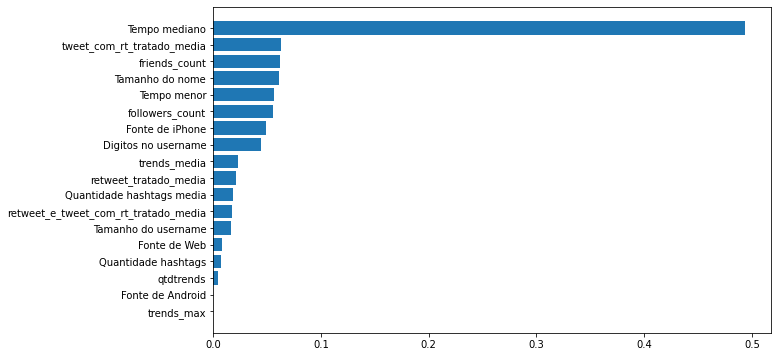

In [ ]:
importances = classifier.feature_importances_

indices = np.argsort(importances)

fig, ax = plt.subplots(figsize =(10, 6))
ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))
_ = ax.set_yticklabels(np.array(x_novo_trend.columns)[indices])

**Resultados**

Os resultados ainda demandam de maior avaliação, especialmente com a variação da semente aleatória para os cortes do conjunto de treinamento e para a aplicação dos métodos. Ainda nesse sentido, demanda-se ainda da seleção de modelos baseada na otimização dos hiperparâmetros dos métodos aplicados.

Mesmo com essas demandas, observa-se uma acurácia aproximada de 74% para os métodos (e aproximadamente 70% ao considerar-se o desbalanceamento da base). Valor considerado bom, dado o complexo cenário tratado. 

Importante ponto a ser destacado que o valor da acurácia baseia-se também em um ponto de corte da consistência da classificação, a qual pode variar en 0.0 e 1.0, valores que atrelam-se à probabilidade da classificação, em que por padrão adota-se o corte em 0.5, apesar da aplicação pode gerar um intervalo mais restrito, deslocando a média/mediana das predições. Dito isso e considerando que não deva ser utilizado apenas o corte "bruto" de bot ou não bot, a associação dessa probabilidade permite melhor compreensão do "risco" do usuário ser efetivamente um bot, bem como permite um deslocamento do rigor dessa classificação. 

Os trechos a seguir avaliam a acurácia considerando a mediana das predições como corte, bem como a comparação dos valores preditos nos grupos de usuários previamente (manualmente) classificados como bot ou não, no qual verifica-se uma clara separação dos valores preditos.

In [ ]:
#x_new_trend = SelectKBest(chi2, k=10).fit_transform(x_novo_trend, y)

In [ ]:
#x_train, x_test, y_train, y_test = train_test_split(x_new_trend, y, test_size=0.3, random_state=1) 

In [ ]:
#classifier = RandomForestClassifier(n_jobs=3, random_state=1, n_estimators=100)
#classifier = classifier.fit(x_train,y_train)
#y_pred = classifier.predict(x_test)
#mean = np.mean(y_pred == y_test)
#balanced = balanced_accuracy_score(y_test, y_pred)
#print ("Mean: " + str(mean) + " | Balanced accuracy: " + str(balanced))
#confusion_matrix(y_test, y_pred)

In [ ]:
#x_new_trend

In [ ]:
#confusion_matrix(y_test, y_pred)

In [ ]:
y_pred

array([0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 0, 1, 1])

In [ ]:
classifier.predict_proba(x_test)

array([[0.82234616, 0.17765384],
       [0.06307788, 0.93692212],
       [0.96424636, 0.03575364],
       [0.18783281, 0.81216719],
       [0.19107317, 0.80892683],
       [0.9434401 , 0.0565599 ],
       [0.55484673, 0.44515327],
       [0.81912638, 0.18087362],
       [0.1072045 , 0.8927955 ],
       [0.41184308, 0.58815692],
       [0.02048731, 0.97951269],
       [0.7882086 , 0.2117914 ],
       [0.12182653, 0.87817347],
       [0.16023543, 0.83976457],
       [0.21667676, 0.78332324],
       [0.13156947, 0.86843053],
       [0.06477248, 0.93522752],
       [0.55086252, 0.44913748],
       [0.0583293 , 0.9416707 ],
       [0.20576939, 0.79423061],
       [0.03236921, 0.96763079],
       [0.0346709 , 0.9653291 ],
       [0.33333473, 0.66666527],
       [0.44441443, 0.55558557],
       [0.50592871, 0.49407129],
       [0.75879899, 0.24120101],
       [0.09265759, 0.90734241],
       [0.84428435, 0.15571565],
       [0.3508184 , 0.6491816 ],
       [0.03358033, 0.96641967],
       [0.

In [ ]:
predicted_proba = classifier.predict_proba(x_test)[0]

In [ ]:
y_test

73     0
551    1
117    0
372    1
216    1
      ..
344    1
40     1
89     0
453    1
605    1
Name: É Bot?, Length: 251, dtype: int64

In [ ]:
np.median(classifier.predict_proba(x_test)[:,1])

0.7796670548979613

In [ ]:
threshold = 0.6
predicted = (classifier.predict_proba(x_test)[:,1] >= threshold).astype(bool)

In [ ]:
np.mean(predicted == y_test)

0.7609561752988048

In [ ]:
x_test_geral = x_test
dtf = [x_test, x_train]
x_test_geral = pd.concat(dtf)

834


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


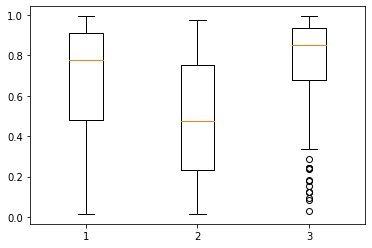

In [ ]:
print(len(x_test_geral))
y_test_temp = y_test
y_test_temp.reset_index(drop=True, inplace=True)
y_test_temp[y_test_temp == 1].index
res_geral = classifier.predict_proba(x_test_geral)[y_test_temp.index,1]
res_sim = classifier.predict_proba(x_test_geral)[y_test_temp[y_test_temp == 1].index,1]
res_nao = classifier.predict_proba(x_test_geral)[y_test_temp[y_test_temp == 0].index,1]

np.median(res_sim)
np.median(res_nao)
bplots = plt.boxplot([res_geral, res_nao, res_sim],  vert = 1, patch_artist = False)

In [ ]:
pd.DataFrame({"Não": res_nao}).describe()

,Não
count,84.000000
mean,0.479382
std,0.284891
min,0.014898
25%,0.232253
50%,0.475195
75%,0.750450
max,0.973344


In [ ]:
pd.DataFrame({"Sim": res_sim}).describe()

,Sim
count,167.000000
mean,0.767758
std,0.233861
min,0.030042
25%,0.678627
50%,0.850146
75%,0.938179
max,0.994026


**Comparação com as predições do Botometer**

Visando a avaliar a qualidade da classificação dos modelos gerados, os mesmos usuários passaram pela avaliação da ferramenta Botometer, já bem conhecida e amplamente utilizada (apesar de sua aplicação com enfoque nas publicações em Inglês).

In [ ]:
#Lê os dados da aplicação do botometer
#Busca os dados dos usuários avaliados
datafile_botometer = "/content/sample_data/handles_inct.csv"
df_botometer = pd.read_csv(datafile_botometer, header = 0)
#Preenche os valores NaN con 0 apenas para avaliação geral
df_botometer = df_botometer.fillna(0)
print(len(df_botometer))
df_botometer.head()

1074


,Unnamed: 0,Unnamed: 0.1,tabelaAmostra,p,É Bot?,"Se você fosse atribuir uma função ao bot, qual seria?",Função #2,Comportamento agressivo?,Comportamento repetitivo com # ou menções?,Parece só Retweetar?,Só compartilha links?,Só faz comentários?,Enaltece muito outros usuários?,Faz muito uso de emojis?,Tem muitos posts sem textos?,Unnamed: 14,handle
0,0,1,https://twitter.com/@lemathes,0000.csv,não,não se aplica,0,não,não,não,não,não,não,não,não,0,lemathes
1,1,2,https://twitter.com/@Maurcio98905595,0000.csv,não,não se aplica,0,não,não,não,não,não,não,não,não,0,Maurcio98905595
2,2,3,https://twitter.com/@LunViana,0000.csv,não,não se aplica,0,não,não,não,não,não,não,não,não,0,LunViana
3,3,4,https://twitter.com/@felipeleixas,0000.csv,sim,Publicar hashtags,Atacar,sim,sim,não,não,não,não,não,não,0,felipeleixas
4,4,5,https://twitter.com/@JoseCar41451194,0000.csv,Não,não se aplica,0,não,não,não,não,não,não,não,não,0,JoseCar41451194


In [ ]:
#Avalia os resultados do botometer
a = len(df_botometer['analise_botometer'])
b = len(df_botometer[(df_botometer['É Bot?'] == 'não') | (df_botometer['É Bot?'] == 'Não')]['analise_botometer'])
c = len(df_botometer[(df_botometer['É Bot?'] == 'sim') | (df_botometer['É Bot?'] == 'Sim')]['analise_botometer'])
print(" " + str(a) + " = " + str(b) + " + " + str(c))
botometer_geral = df_botometer['analise_botometer']
botometer_nao   = df_botometer[(df_botometer['É Bot?'] == 'não') | (df_botometer['É Bot?'] == 'Não')]['analise_botometer']
botometer_sim   = df_botometer[(df_botometer['É Bot?'] == 'sim') | (df_botometer['É Bot?'] == 'Sim')]['analise_botometer']

KeyError: ignored

In [ ]:
plt.figure(figsize =(20, 10)) #(11, 6)
bplots = plt.boxplot([botometer_geral/5, botometer_nao/5, botometer_sim/5, res_geral, res_nao, res_sim],  vert = 1, patch_artist = False)
colors = ['blue', 'green', 'red', 'lightblue', 'lightgreen', 'pink']
c = 0
for i, bplot in enumerate(bplots['boxes']):
    bplot.set(color=colors[c], linewidth=3)
    c += 1
    
colorss = ['blue','blue', 'green', 'green', 'red', 'red', 'lightblue', 'lightblue', 'lightgreen', 'lightgreen', 'pink', 'pink' ]    
c3 = 0
for cap in bplots['caps']:
    cap.set(color=colorss[c3], linewidth=3)
    c3 +=1

plt.title("Boxplot da avaliação do Botometer e do novo modelo Pegabot para os dados avaiados no INCT-DD", loc="center", fontsize=18)
plt.xlabel("Agrupados por: (1) Botometer Geral; (2) Botometer apenas considerados não bots; (3) Botometer apenas considerados bots; (4) Novo Pegabot Geral; (5) Novo Pegabot apenas considerados não bots; (6) Novo Pegabot apenas considerados bots")
plt.ylabel("Avaliação do Botometer")

plt.show()

NameError: ignored

<Figure size 1440x720 with 0 Axes>

In [ ]:
import scipy
scipy.stats.kruskal(botometer_geral,  botometer_nao,botometer_sim)

In [ ]:
scipy.stats.kruskal(res_geral,  res_nao,res_sim)

<h1> Análise de Sentimento</h1>

<h2>Objetivo</h2>

Criar um novo atributo que possa ser utilizado no motor aplicando análise de sentimento para indicar com base no texto do twitte se ele é agresssivo ou não.

Para esse primeiro teste fazer merge dos dataframes já gerados (df_handles, df_users e df_result_text) de forma a obter um novo dataframe que contenha os seguintes atributos: 'Comportamento agressivo?', 'tweet_author', 'tweet_text_y'

In [15]:
!pip install nltk
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [161]:
! pip install nltk.examples

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement nltk.examples (from versions: none)
ERROR: No matching distribution found for nltk.examples


In [253]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.test.portuguese_en_fixt import setup_module
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import  TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from scipy.stats import ks_2samp
from imblearn.over_sampling import SMOTE

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [273]:
df_handles['Comportamento agressivo?'].head()

0    não
1    não
2    não
3    sim
4    não
Name: Comportamento agressivo?, dtype: object

In [274]:
#Seleção do texto e com o rótulo é agressivo ou não
df_result_merge_text = pd.merge(df_handles, df_users, on=['handle'])
df_result_merge_text = pd.merge(df_result_merge,df_result_text, left_on=['handle'], right_on=['tweet_author'])
print(len(df_result_merge_text))
df_result_merge_text.head(1)

834


,Unnamed: 0_x,Unnamed: 0.1,tabelaAmostra,p,É Bot?,"Se você fosse atribuir uma função ao bot, qual seria?",Função #2,Comportamento agressivo?,Comportamento repetitivo com # ou menções?,Parece só Retweetar?,...,lang,location,name,profile_image,twitter_id,twitter_is_protected,verified,withheld_in_countries,tweet_author,tweet_text
0,0,1,https://twitter.com/@lemathes,0000.csv,não,não se aplica,NaN,não,não,não,...,0.0,"Brasil, São Paulo",Leandro Mathes,http://pbs.twimg.com/profile_images/1141547105...,52253248.0,0.0,0.0,[],lemathes,"@LucianoHangBr Já demorou muito!, RT @LucianoH..."


In [275]:
df_result_merge_text['Comportamento agressivo?'] = df_result_merge_text['Comportamento agressivo?'].str.lower()
df_result_merge_text['tweet_text'] = df_result_merge_text['tweet_text'].str.lower()

In [276]:
df_result_merge_text_analise=df_result_merge_text[['Comportamento agressivo?', 'tweet_author', 'tweet_text']]
print("\nDimensões:\n")
print("Shape:", df_result_merge_text_analise.shape)
print("\nQuantidade de dados faltantes:\n")
print(df_result_merge_text_analise.isnull().sum())


Dimensões:

Shape: (834, 3)

Quantidade de dados faltantes:

Comportamento agressivo?    0
tweet_author                0
tweet_text                  0
dtype: int64


In [277]:
df_result_merge_text_analise['Tamanho'] = df_result_merge_text_analise['tweet_text'].apply(len)
print("Tamanho dos comentários:\n")
df_result_merge_text_analise.head()

Tamanho dos comentários:



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Comportamento agressivo?,tweet_author,tweet_text,Tamanho
0,não,lemathes,"@lucianohangbr já demorou muito!, rt @lucianoh...",10004
1,não,Maurcio98905595,"hospício....louca. https://t.co/34bby21hrq, . ...",7015
2,não,LunViana,rt @jairbolsonaro: - rio de janeiro / rj: o @g...,11420
3,sim,felipeleixas,@rachelsherazade vc chama isso de jornalismo? ...,2846
4,não,JoseCar41451194,"rt @brazilfight: janaína paschoal\n""jamais um ...",11465


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribuição do tamanho do texto')

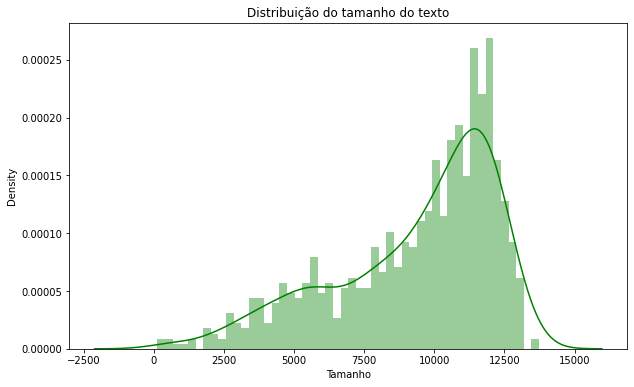

In [278]:
df_dist_grafico = plt.figure(figsize=(10,6))
sns.distplot(df_result_merge_text_analise['Tamanho'], kde=True, bins=50, color="green")
plt.title('Distribuição do tamanho do texto')

In [279]:
#total de sim e não
total = df_result_merge_text_analise['Comportamento agressivo?'].count()
total_sim = (df_result_merge_text_analise['Comportamento agressivo?']=='sim').sum()
total_nao = (df_result_merge_text_analise['Comportamento agressivo?']=='não').sum()
print("Total:", total)
print("Total de sim:", total_sim)
print("Total de não:", total_nao)

Total: 834
Total de sim: 98
Total de não: 735


<h2> Problema 1</h2>

Nos dados disponíveis existem um desbalanceamento das classes Comportamento agressivo? (sim ou não), onde a classe 'não' é a majoritória e a classe 'sim' a minotória. Isso induzirá o algoritmo de classificação a tender mais para a classe majoritária prejudicando na acurácia do modolo.

Existem métodos para tratamento de classes desbanlanceadas como o **Undersampling** e o **Oversampling**.

*  **Undersampling**: é uma técnica que consiste em manter todos os dados da classe com menor frequência (minoritária) e diminuir a quantidade dos que estão na classe de maior frequência (majoritária), fazendo com que as observações no conjunto possuam dados com a variável alvo equilibrada. Uma das técnicas mais utilizadas é o Near Miss que diminui aleatoriamente a quantidade de valores da classe majoritária. Vale destacar que o Near Miss utiliza a menor distância média dos K-vizinhos mais próximos, ou seja, seleciona os valores baseando-se no método KNN (K-nearest neighbors) para reduzir a perda de informação.
*   **Oversampling**:  é uma técnica que consiste em aumentar a quantidade de registros da classe com menor frequência até que a base de dados possua uma quantidade equilibrada entre as classes da variável alvo. Para evitar que existam muitos dados idênticos, pode ser utilizada a técnica SMOTE (Synthetic Minority Over-sampling Technique), que consiste em sintetizar novas informações com base nas já existentes. Esses dados “sintéticos” são relativamente próximos aos dados reais, mas não são idênticos. 

**Referências:**
https://www.alura.com.br/artigos/lidando-com-desbalanceamento-dados
https://acervolima.com/ml-manipulacao-de-dados-desequilibrados-com-smote-e-algoritmo-de-quase-perda-em-python/

In [280]:
texto = df_result_merge_text_analise[['Comportamento agressivo?', 'tweet_author', 'tweet_text']]
texto['Tamanho'] = texto['tweet_text'].apply(len)

In [281]:
texto['tweet_text'] = texto['tweet_text'].str.replace("rt", "")
texto['tweet_text'] = texto['tweet_text'].str.replace("https", "")
#texto['tweet_text'] = texto['tweet_text'].str.replace("@", "")
#texto['tweet_text'] = texto['tweet_text'].str.replace("#", "")
texto['tweet_text']

0      @lucianohangbr já demorou muito!,  @lucianohan...
1      hospício....louca. ://t.co/34bby21hrq, . ://t....
2       @jairbolsonaro: - rio de janeiro / rj: o @gov...
3      @rachelsherazade vc chama isso de jornalismo? ...
4       @brazilfight: janaína paschoal\n"jamais um br...
                             ...                        
829     @claudeluca_: alguém tem notícia de quando vã...
830    @dindorio te seguindo, patriota !!! sdv ????\n...
831    @beta_jesse 👏👏👏👏 por isso #lavajatoorgulhodobr...
832     @drbots2: ---\njustiça condena influenciador ...
833    @camelojubeni @konigmachado @marcos_28_11_66 @...
Name: tweet_text, Length: 834, dtype: object

In [282]:
#stopWord = stopwords.words("portuguese")
stopWords = nltk.corpus.stopwords.words('portuguese')

In [284]:
def remove_puntuacao_stopwords(texto):

    remove_puntacao = [word for word in texto.lower() if word not in string.punctuation]
    remove_puntacao = ''.join(remove_puntacao)
    return [word for word in remove_puntacao.split() if word not in stopWord]

In [285]:
texto_preprocessado = texto.copy()
texto_preprocessado['tweet_text'] = texto['tweet_text'].apply(remove_puntuacao_stopwords)
texto_preprocessado['Tamanho'] = texto_preprocessado['tweet_text'].apply(len)
print("Tamanho dos comentários após aplicação do stopword:\n")
texto_preprocessado.head()

Tamanho dos comentários após aplicação do stopword:



,Comportamento agressivo?,tweet_author,tweet_text,Tamanho
0,não,lemathes,"[lucianohangbr, demorou, lucianohangbr, vida, ...",871
1,não,Maurcio98905595,"[hospíciolouca, tco34bby21hrq, tcol9zmyju15t, ...",527
2,não,LunViana,"[jairbolsonaro, rio, janeiro, rj, govbr, meio,...",1026
3,sim,felipeleixas,"[rachelsherazade, vc, chama, jornalismo, vídeo...",252
4,não,JoseCar41451194,"[brazilfight, janaína, paschoal, jamais, brasi...",1036


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribuição do tamanho do texto após aplicação de STOPWORD')

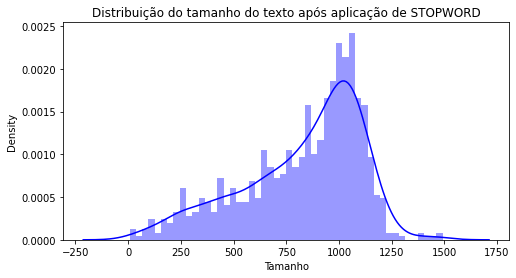

In [286]:
df_dist_grafico_processado = plt.figure(figsize=(8,4))
sns.distplot(texto_preprocessado['Tamanho'], kde=True, bins=50, color="blue")
plt.title('Distribuição do tamanho do texto após aplicação de STOPWORD')

In [287]:
def grafico_frequencia(data):
    plt.figure(figsize=(10,5))
    FreqDist(np.concatenate(data.tweet_text.reset_index(drop=True))).plot(25, cumulative=False, color="green")

Gráfico de frequência de Comportamento agressivo = sim:



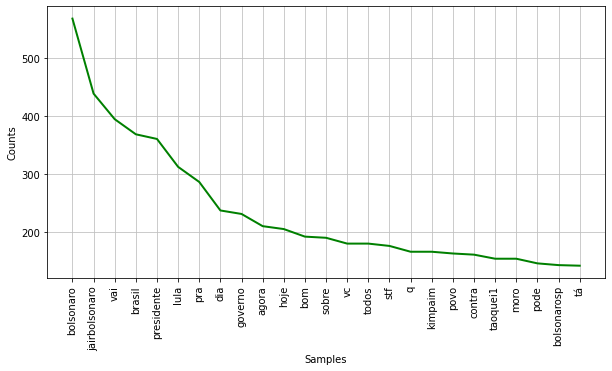

In [288]:
print("Gráfico de frequência de Comportamento agressivo = sim:\n")
grafico_frequencia(texto_preprocessado[texto_preprocessado['Comportamento agressivo?']=='sim'])

Gráfico de frequência de Comportamento agressivo = não:



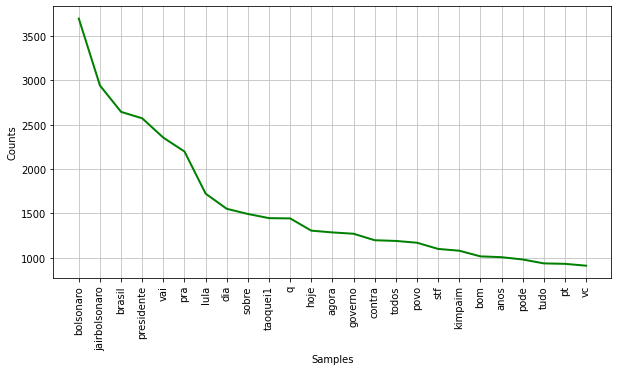

In [289]:
print("Gráfico de frequência de Comportamento agressivo = não:\n")
grafico_frequencia(texto_preprocessado[texto_preprocessado['Comportamento agressivo?']=='não'])

In [290]:
def nuvem_palavras(Agressivo):
    Agressivotexto = ' '.join(texto[texto['Comportamento agressivo?']==Agressivo]['tweet_text'])
    wordcloud = WordCloud(
        width = 3000,
        height = 2000,
        background_color = 'black',
        colormap="hsv",
        stopwords = STOPWORDS).generate(str(Agressivotexto))

    fig = plt.figure(
        figsize = (10, 5),
        facecolor = 'k',
        edgecolor = 'k',)
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)

Nuvem de palavras para agressivo sim:



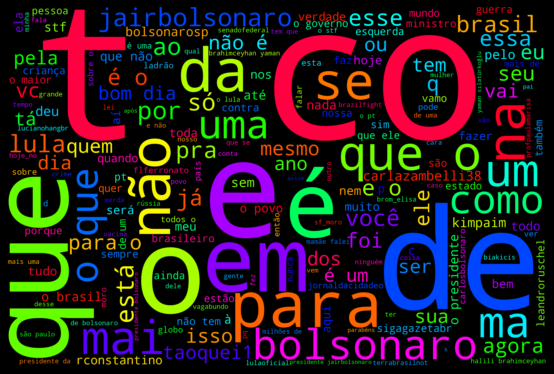

In [291]:
print("Nuvem de palavras para agressivo sim:\n")
nuvem_palavras('sim')

Nuvem de palavras para agressivo não:



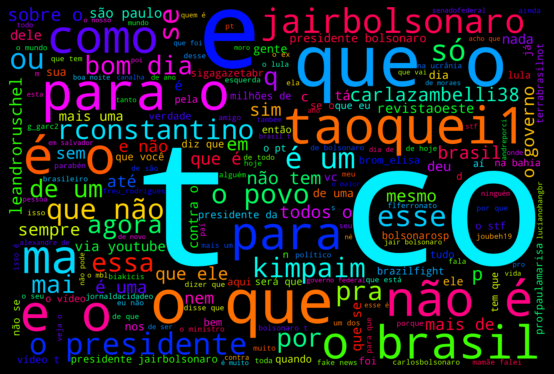

In [292]:
print("Nuvem de palavras para agressivo não:\n")
nuvem_palavras('não')

In [293]:
#Padroniza a saída da classificação do INCT-DD para bot e monta o conjunto Y
texto_preprocessado

,Comportamento agressivo?,tweet_author,tweet_text,Tamanho
0,não,lemathes,"[lucianohangbr, demorou, lucianohangbr, vida, ...",871
1,não,Maurcio98905595,"[hospíciolouca, tco34bby21hrq, tcol9zmyju15t, ...",527
2,não,LunViana,"[jairbolsonaro, rio, janeiro, rj, govbr, meio,...",1026
3,sim,felipeleixas,"[rachelsherazade, vc, chama, jornalismo, vídeo...",252
4,não,JoseCar41451194,"[brazilfight, janaína, paschoal, jamais, brasi...",1036
...,...,...,...,...
829,não,CesarNi85939384,"[claudeluca, alguém, notícia, vão, cassar, man...",1026
830,não,PauloRo49195361,"[dindorio, seguindo, patriota, sdv, fechadocom...",680
831,não,Marina92011959,"[betajesse, 👏👏👏👏, lavajatoorgulhodobrasil, tas...",669
832,não,Marcos_28_11_66,"[drbots2, justiça, condena, influenciador, ass...",1057


<h2> Problema 2</h2>

Apesar de ter retirado as stopwords, os textos do Twitter conté muitos rt, https, emojis que precisam ser removidos de forma a deixa apenas texto útil. Isso pode ser visualizado nos gráficos de frequência e núvens de palavras que foram gerados.

É necessário pensar numa forma de remover isso do texto, seja por expressão regular ou por meio de código em Python

In [294]:
x = texto_preprocessado['tweet_text']
x.head()

0    [lucianohangbr, demorou, lucianohangbr, vida, ...
1    [hospíciolouca, tco34bby21hrq, tcol9zmyju15t, ...
2    [jairbolsonaro, rio, janeiro, rj, govbr, meio,...
3    [rachelsherazade, vc, chama, jornalismo, vídeo...
4    [brazilfight, janaína, paschoal, jamais, brasi...
Name: tweet_text, dtype: object

In [295]:
y = texto_preprocessado['Comportamento agressivo?'].apply(lambda x: 1 if (x == 'sim') else 0)
y.reset_index(drop=True, inplace=True)
y.head()

0    0
1    0
2    0
3    1
4    0
Name: Comportamento agressivo?, dtype: int64

In [297]:
vetorizar = CountVectorizer(analyzer=lambda x: x).fit(x)
x = vetorizar.transform(x)

In [298]:
print("Dimensões da matrix esparsa: ", x.shape)

Dimensões da matrix esparsa:  (834, 102549)


In [299]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [300]:
smt = SMOTE(k_neighbors=5, random_state=42)
x_train, y_train = smt.fit_resample(x_train, y_train)
#x_train, y_train = smt.fit_resample(x_train, y_train)
np.bincount(y_train)

array([524, 524])

In [301]:
mnb = MultinomialNB()

mnb.fit(x_train,y_train)
predicao_mnb = mnb.predict(x_test)

In [302]:
print("Matriz de Confusão - Multinomial Naive Bayes:\n")
print(confusion_matrix(y_test,predicao_mnb))
print("\nRelatório de Classificação:",classification_report(y_test,predicao_mnb))

Matriz de Confusão - Multinomial Naive Bayes:

[[200  12]
 [ 37   2]]

Relatório de Classificação:               precision    recall  f1-score   support

           0       0.84      0.94      0.89       212
           1       0.14      0.05      0.08        39

    accuracy                           0.80       251
   macro avg       0.49      0.50      0.48       251
weighted avg       0.73      0.80      0.76       251



In [258]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Matriz de Confusão',
                          cmap=plt.cm.Blues):
    """
    Esta função imprime e plota a matriz de confusão.
    A normalização pode ser aplicada definindo `normalize = True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de confusão normalizada\n")
    else:
        print('Matriz de confusão sem normalização\n')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Matriz de confusão sem normalização

[[200  12]
 [ 37   2]]


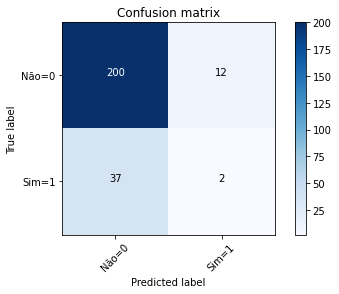

In [259]:
# Calculando a confusion matrix
matriz_confusao = confusion_matrix(y_test, predicao_mnb, labels=[0,1])
np.set_printoptions(precision=2)
# Imprimindo a matriz de confusão sem normalização
plt.figure()
plot_confusion_matrix(matriz_confusao, classes=['Não=0','Sim=1'],normalize= False,  title='Confusion matrix')

<h2> Análise do Resultado</h2>

Pela matriz de confusão é possível observar que o modelo foi muito assertivo em classificar a classe "agressivo = não", justamente por ela ser a classe majoritária acertando 198 e errando apenas 14, e foi muito ruim em classificar a classe "agressivo = sim", acertando apenas 1.



<h1>Classificação do tipo de bot</h1>

<h2>Objetivo</h2>

Criar um novo atributo que indique a classificação do tipo de bot tomando com esse rótulo já existente no dataframe df_handles.

Para esse classificador é necessário analisar os demais atributos dos outros dataframes para um levantamento dos que sejam mais úteis para ajudar na modelagem desse classificador.

In [57]:
#Lista as funções atribuídas ao bots
funcao_bot = df_handles['Se você fosse atribuir uma função ao bot, qual seria?'].unique()
funcao_bot

array(['não se aplica', 'Publicar hashtags', 'Compartilhar links',
       'publicar hashtags', 'Retweetar', 'compartilhar links', 'Postar',
       'Responder', 'compartilhar links ', 'Comentar', 'Atacar',
       'retweetar', 'atacar', 'Publicar imagens ou vídeos',
       'Mostrar Tweets apagados de atores políticos'], dtype=object)

<h1>Classifiacação de emoji</h1>

<h2>Objetivo</h2>

Classificar os emoji de acordo com o signifcado dos mesmos


O link abaixo lista os principais emoji
https://gist.github.com/rxaviers/7360908

A figura abaixo mostra a quantidade dos emojis mais usados agrupados por categorias (Amor, Felicidade, etc)

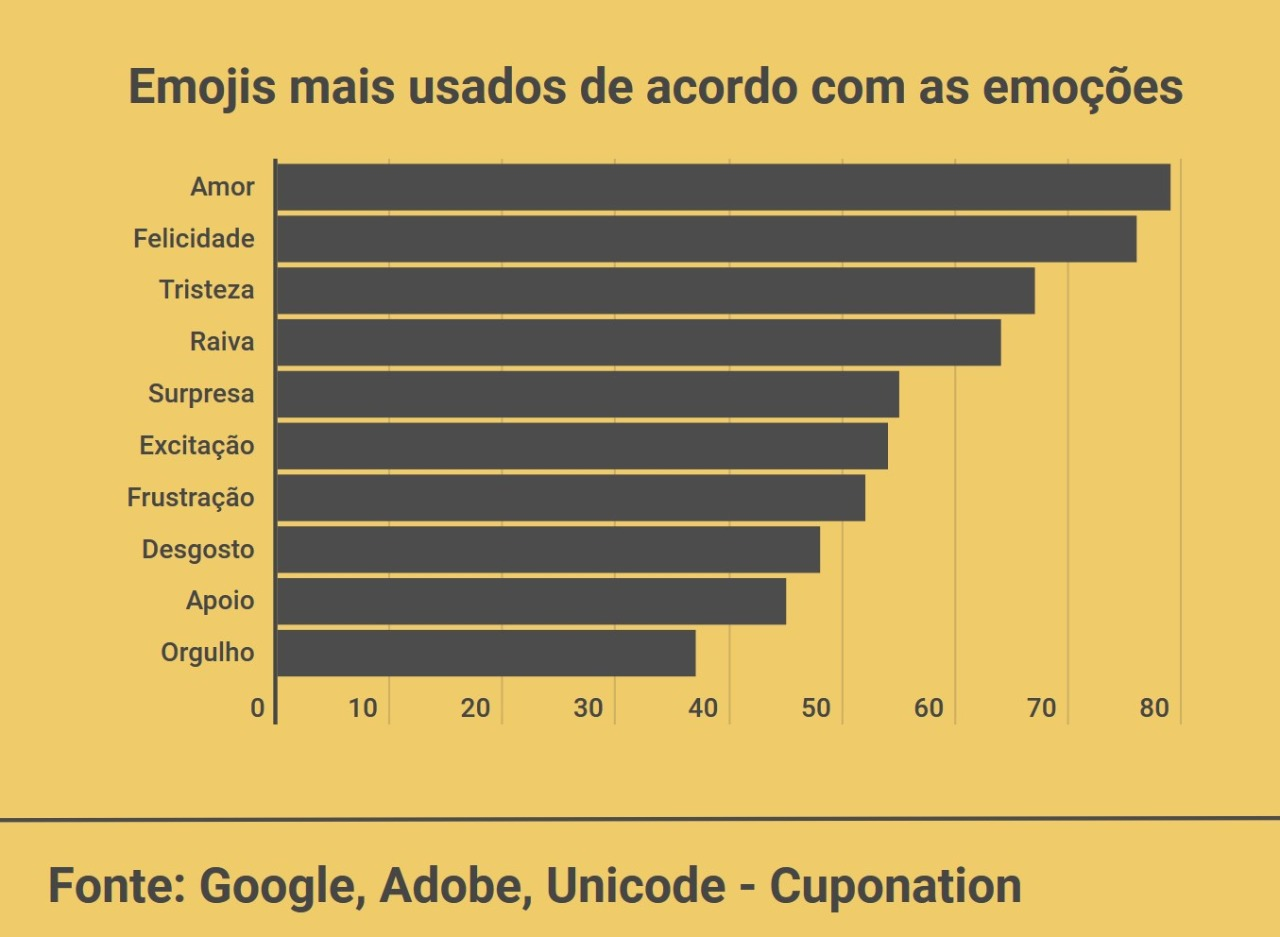